In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab
import os
import sys
import time

import numpy as np
import h5py

from librosa.feature import melspectrogram
from librosa import logamplitude

from matplotlib import mlab
from matplotlib import gridspec
from scipy.interpolate import interp1d

mpl.rcParams['agg.path.chunksize'] = 10000

In [3]:
def get_psd(real_strain, sampling_rate=4096):

    # Define some constants
    nfft = 2 * sampling_rate  # Bigger values yield better resolution?

    # Use matplotlib.mlab to calculate the PSD from the real strain
    P_xx, freqs = mlab.psd(real_strain, NFFT=nfft, Fs=sampling_rate)

    # Interpolate it linearly, so we can re-sample the spectrum arbitrarily
    psd = interp1d(freqs, P_xx)

    return psd


def apply_psd(signal_t, psd, sampling_rate=4096):
    """
    Take a signal in the time domain, and a precalculated Power Spectral
    Density, and color the signal according to the given PSD.

    Args:
        signal_t: A signal in time domain (i.e. a 1D numpy array)
        psd: A Power Spectral Density, e.g. calculated from the detector noise.
            Should be a function: psd(frequency)
        sampling_rate: Sampling rate of signal_t

    Returns: color_signal_t, the colored signal in the time domain.
    """

    # First set some parameters for computing power spectra
    n = len(signal_t)
    dt = 1./sampling_rate

    # Go into Fourier (frequency) space: signal_t -> signal_f
    frequencies = np.fft.rfftfreq(n, dt)
    signal_f = np.fft.rfft(signal_t)

    # Divide by the given Power Spectral Density (PSD)
    # This is the 'whitening' = actually adding color
    color_signal_f = signal_f / (np.sqrt(psd(frequencies) / dt / 2.))

    # Go back into time space: color_signal_f -> color_signal_t
    color_signal_t = np.fft.irfft(color_signal_f, n=n)

    return color_signal_t

In [4]:
# Path to the directory where all data is stored
data_path = '../data'

# Read in the HDF file
with h5py.File(os.path.join(data_path, 'strain', 'H1_2017_4096.hdf5')) as file:
    strain = np.array(file['strain/Strain'])

In [5]:
psd = get_psd(strain)

In [6]:
whitened_strain = apply_psd(strain, psd)

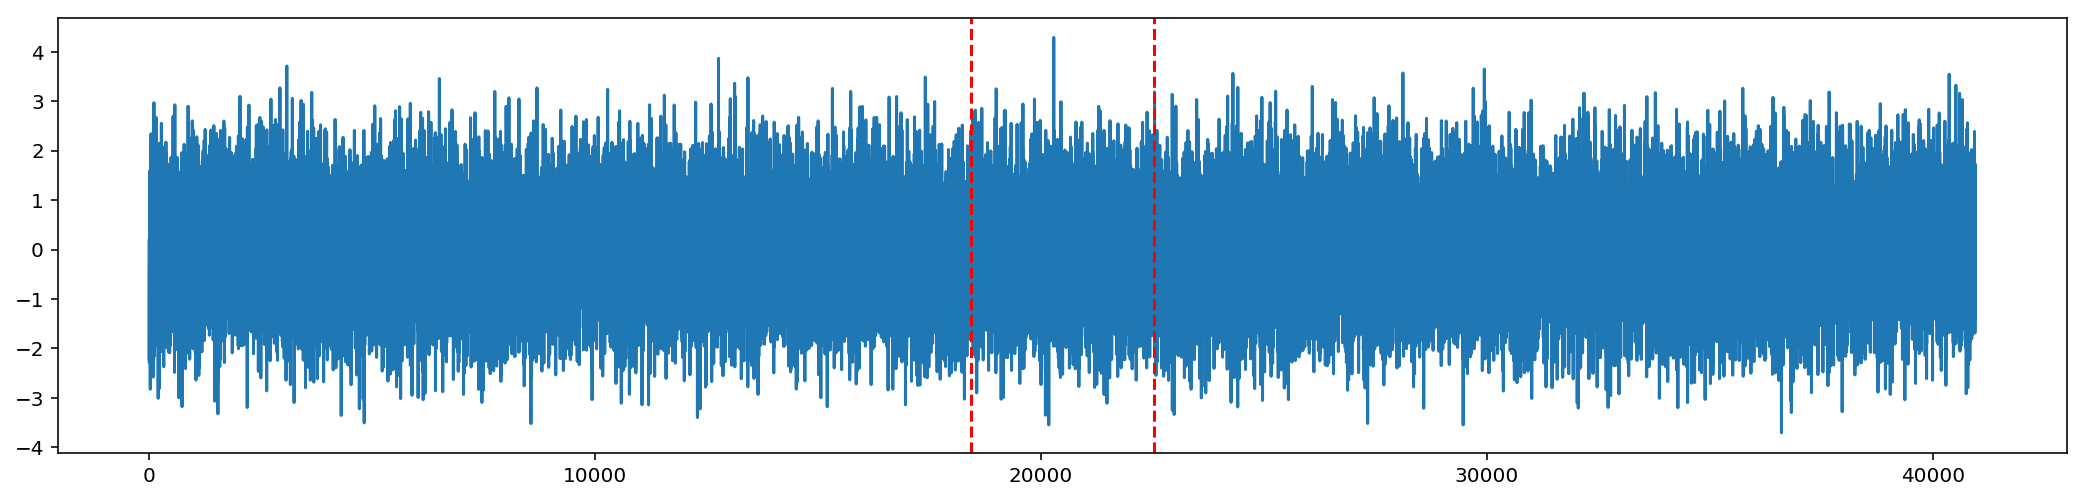

In [7]:
signal = whitened_strain[int(4096*(2048.6-5)):int(4096*(2048.6+5))]
plt.plot(signal)
plt.axvline(x=4.5*4096, ls='--', color='red')
plt.axvline(x=5.5*4096, ls='--', color='red')
plt.gcf().set_size_inches(18, 4, forward=True)
plt.show()

In [8]:
def make_spectrogram(strain):
    result = melspectrogram(strain, sr=4096, n_fft=1024, hop_length=64,
                            n_mels=64, fmin=0, fmax=400)
    return logamplitude(result)

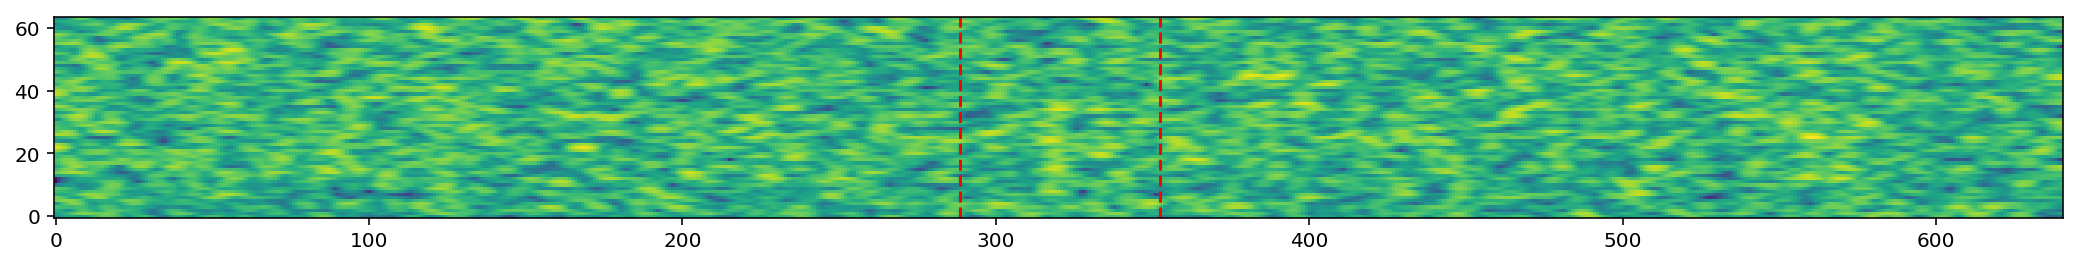

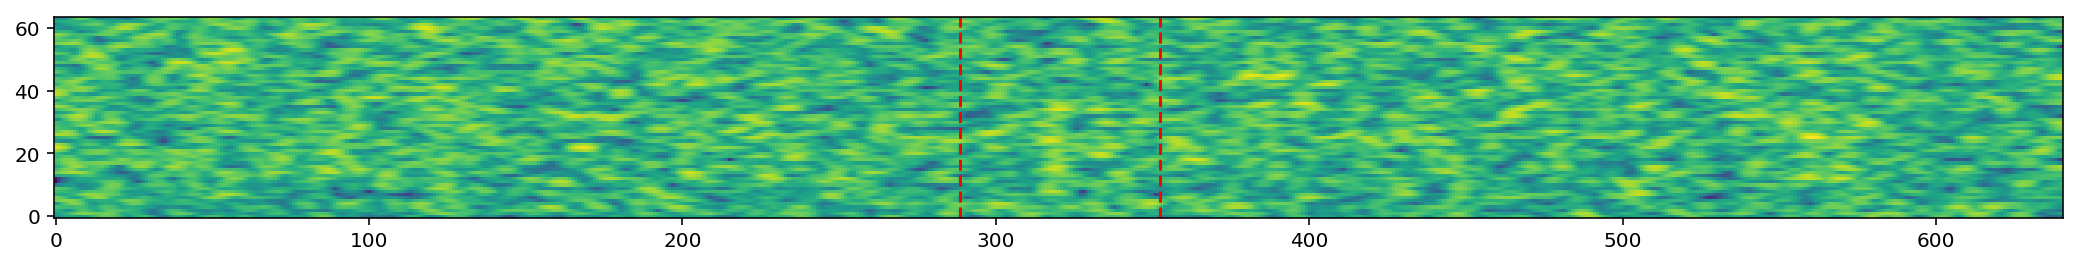

In [9]:
plt.figure(1)
plt.imshow(make_spectrogram(signal), origin="lower", interpolation="none")
plt.gcf().set_size_inches(18, 4, forward=True)
plt.axvline(x=288.45, ls='--', color='red')
plt.axvline(x=352.55, ls='--', color='red')
plt.figure(2)
plt.imshow(make_spectrogram(signal), origin="lower")
plt.gcf().set_size_inches(18, 4, forward=True)
plt.axvline(x=288.45, ls='--', color='red')
plt.axvline(x=352.55, ls='--', color='red')
plt.show()

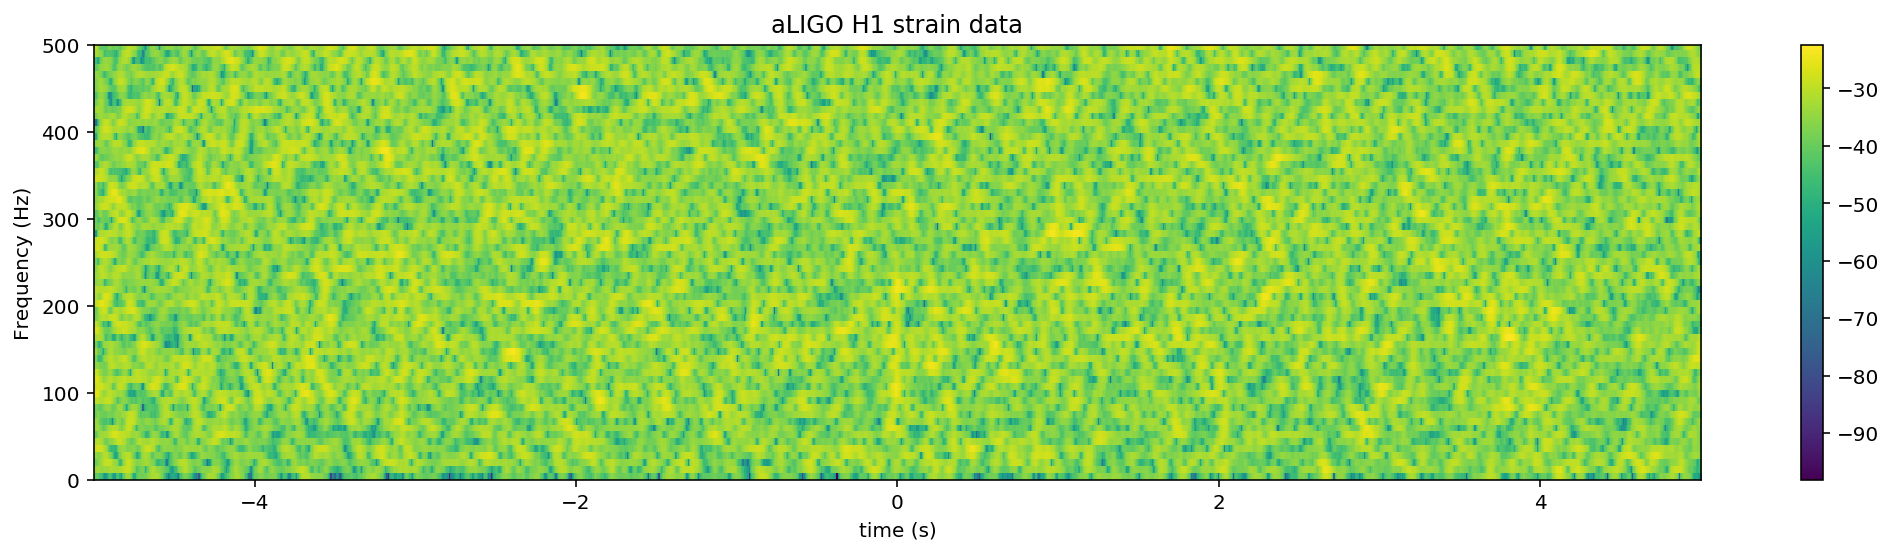

In [10]:
fs = 4096
deltat = 5

# pick a shorter FTT time interval, like 1/8 of a second:
NFFT = int(fs/8)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15./16)
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)
window = np.bartlett(NFFT)

# the right colormap is all-important! See:
# http://matplotlib.org/examples/color/colormaps_reference.html
# viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
spec_cmap='viridis'
#spec_cmap='ocean'

# Plot the H1 spectrogram:
plt.figure(figsize=(10,6))
spec_H1, freqs, bins, im = plt.specgram(signal, NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 500])
plt.title('aLIGO H1 strain data')
plt.gcf().set_size_inches(18, 4, forward=True)
plt.show()